In [2]:
import os
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
from ML_package.utils import ML_Utils
base_controler = ML_Utils()

2025-06-07 18:17:58,935 - INFO - ML_Base_Controller initialized.


In [4]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)

    return images, labels

In [5]:
X_train, y_train = load_mnist(r'D:\Code for tutorials\Machine Learning\datasets\fashion MNIST', kind='train')
X_test, y_test = load_mnist(r'D:\Code for tutorials\Machine Learning\datasets\fashion MNIST', kind='t10k')

# Normalize

In [6]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Reshape for CNN: (N, 1, 28, 28)

In [7]:
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

# ---------------- Step 2: PyTorch Dataset ----------------

In [8]:
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = FashionMNISTDataset(X_train, y_train)
test_dataset = FashionMNISTDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
train_dataset.images.shape
train_loader

# ---------------- Step 3: CNN Model ----------------

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (32, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))  # -> (64, 7, 7)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)


# ---------------- Step 4: Loss and Optimizer ----------------

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# ---------------- Step 5: Train Model ----------------


### Building a traing loop and a testing loop in PyTorch

A couple of things we need in a training loop:
0. Loop through data
1. forward pass (this involves data moving through our model's forward() functions) to make predictions on data - also called forward propagation
2. calculate the loss (compare forward pass predictions to ground truth labels)
3. optimizer zero grad
4. loss.backward() - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. optimizer.step() - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [12]:
import matplotlib.pyplot as plt

def plot_loss_curve(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
epochs = 10
loss_per_epoch = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_per_epoch.append(running_loss/len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.4627
Epoch 2/10, Loss: 0.2918
Epoch 3/10, Loss: 0.2441
Epoch 4/10, Loss: 0.2138
Epoch 5/10, Loss: 0.1903
Epoch 6/10, Loss: 0.1687
Epoch 7/10, Loss: 0.1512
Epoch 8/10, Loss: 0.1317
Epoch 9/10, Loss: 0.1143
Epoch 10/10, Loss: 0.0991


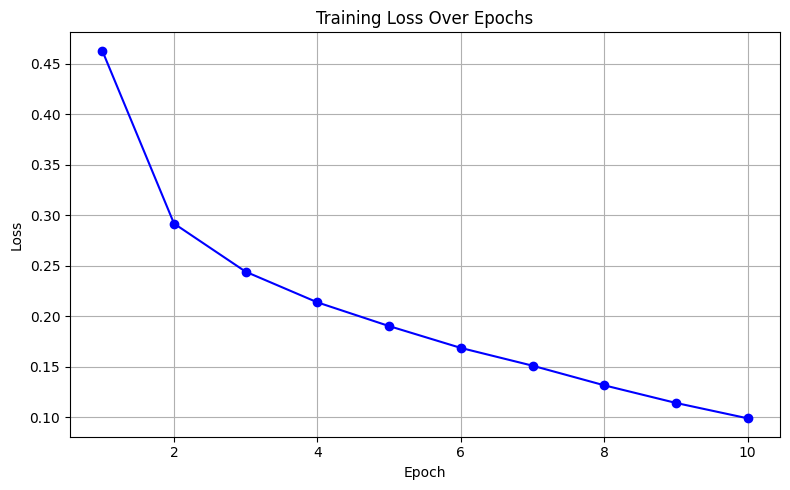

2025-06-07 18:22:07,228 - INFO - Successfully plotted loss curve.


In [14]:
base_controler.plot_loss_curve(loss_per_epoch)

# ---------------- Step 6: Evaluate ----------------

In [15]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"\n✅ Accuracy on test data: {100 * correct / total:.2f}%")


✅ Accuracy on test data: 92.55%


In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (60000, 1, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 1, 28, 28)
y_test shape: (10000,)


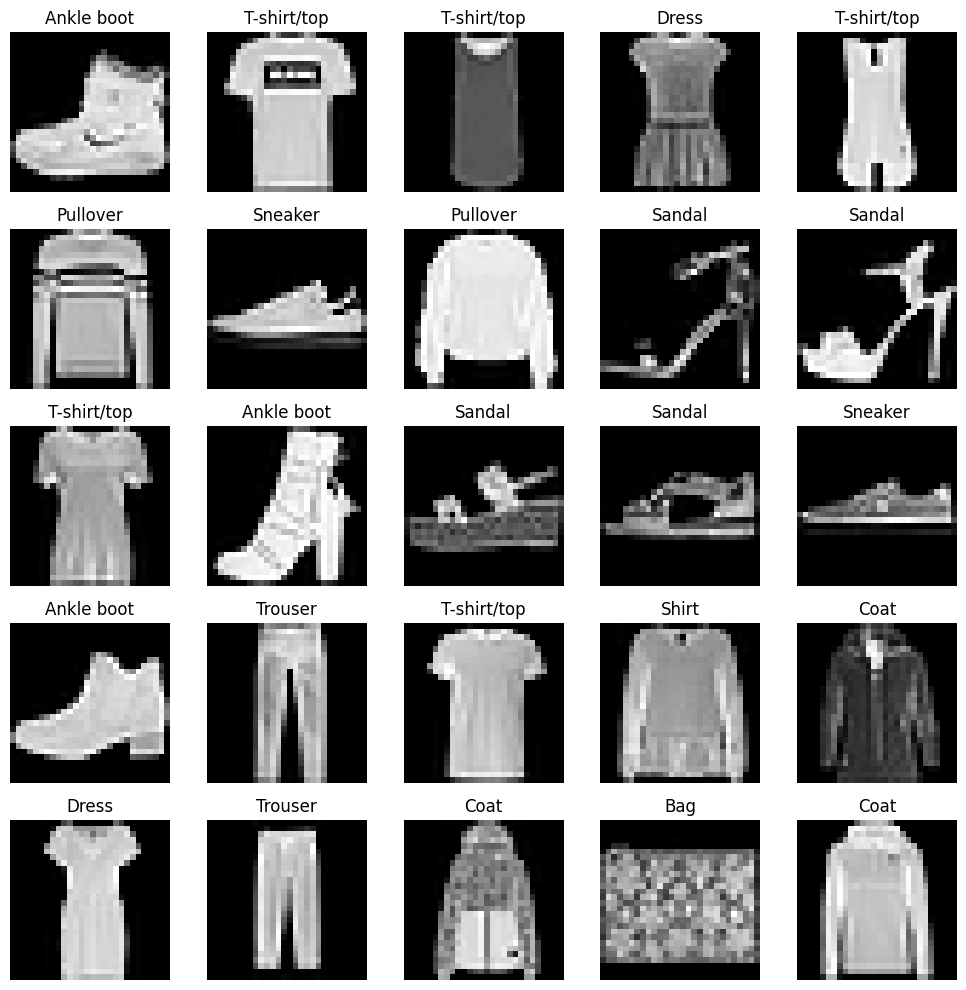

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report


classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_sample_images(images, labels, n=25):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Use first 25 images from training data
show_sample_images(X_train, y_train)

2025-06-07 18:22:10,456 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\DHUSNIC INFANT DM\AppData\Local\Temp\ipykernel_12504\1015809779.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="Set2")
2025-06-07 18:22:10,490 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


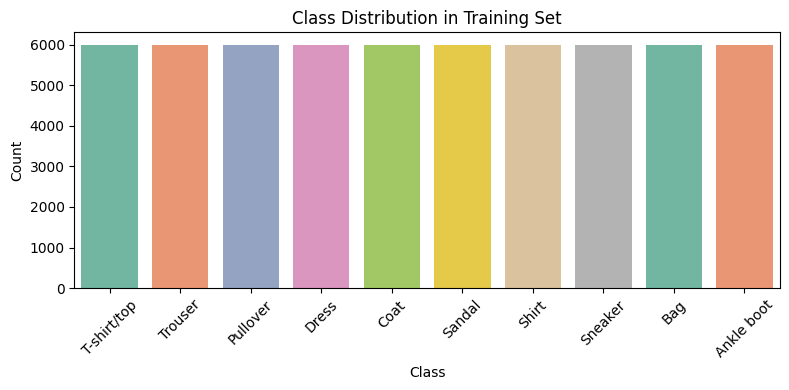

In [18]:
def plot_class_distribution(labels):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=labels, palette="Set2")
    plt.title("Class Distribution in Training Set")
    plt.xticks(ticks=np.arange(10), labels=classes, rotation=45)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_class_distribution(y_train)


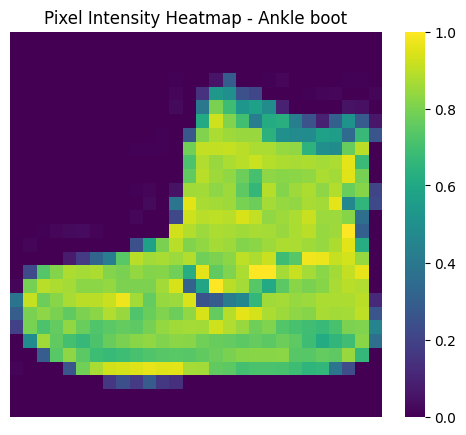

In [19]:
def plot_pixel_heatmap(image_tensor, label_index):
    img = image_tensor[0]  # shape (1, 28, 28)
    plt.figure(figsize=(6, 5))
    sns.heatmap(img.squeeze(), cmap="viridis")
    plt.title(f"Pixel Intensity Heatmap - {classes[label_index]}")
    plt.axis('off')
    plt.show()

# Example: Plot first image
plot_pixel_heatmap(X_train[0], y_train[0])


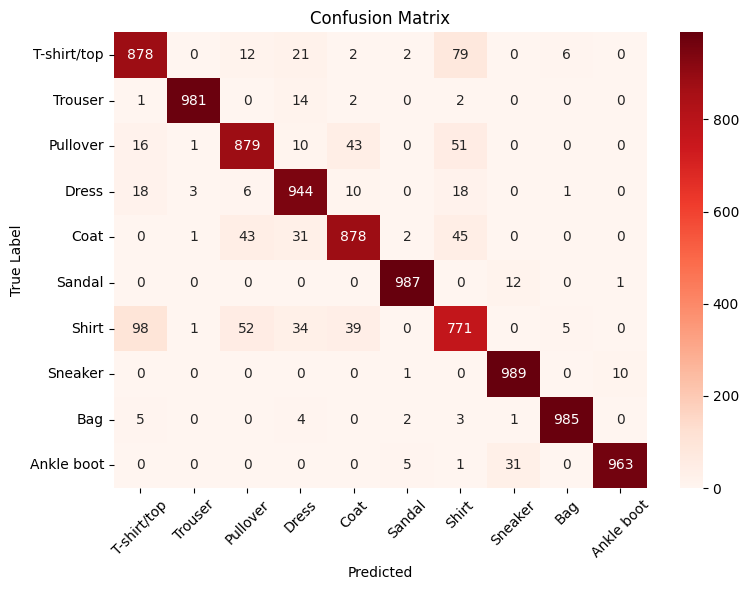

2025-06-07 18:22:14,281 - INFO - ML_Base_Controller initialized.
2025-06-07 18:22:14,281 - INFO - Evaluating model: 
2025-06-07 18:22:14,306 - INFO - [Classification] Model:  - Accuracy: 92.5500%


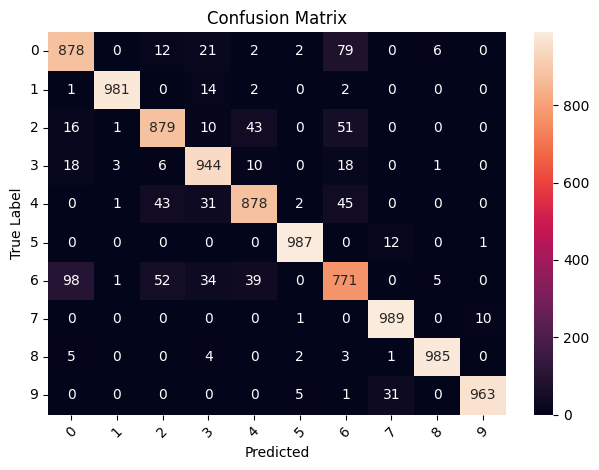

2025-06-07 18:22:14,591 - INFO - [Classification] Model:  - Accuracy: 92.5500%
2025-06-07 18:22:14,592 - INFO - [Regression] Model:  - MSE: 1.1145


Model:  - Accuracy: 92.5500%


{'accuracy_score': 0.9255,
 'mean_squared_error': 1.1145,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.86      0.88      0.87      1000\n           1       0.99      0.98      0.99      1000\n           2       0.89      0.88      0.88      1000\n           3       0.89      0.94      0.92      1000\n           4       0.90      0.88      0.89      1000\n           5       0.99      0.99      0.99      1000\n           6       0.79      0.77      0.78      1000\n           7       0.96      0.99      0.97      1000\n           8       0.99      0.98      0.99      1000\n           9       0.99      0.96      0.98      1000\n\n    accuracy                           0.93     10000\n   macro avg       0.93      0.93      0.93     10000\nweighted avg       0.93      0.93      0.93     10000\n',
 'mean_absolute_error': 0.2551}

In [20]:
def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

plot_confusion_matrix(all_labels, all_preds)

# # Print classification report
# print(classification_report(all_labels, all_preds, target_names=classes))
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(all_labels, all_preds)

from sklearn.ensemble import RandomForestClassifier
from ML_package.utils import ML_Utils
base_controler = ML_Utils()
result = base_controler.evaluate_model(all_labels,all_preds,RandomForestClassifier(),confusion_matrix_plot=True)


result

In [21]:
model.state_dict

<bound method Module.state_dict of CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)>

In [22]:
torch.save(model.state_dict(), "fashion_mnist_cnn.pth")

In [23]:
model = CNN()  # recreate the same model architecture
model.load_state_dict(torch.load("fashion_mnist_cnn.pth"))

<All keys matched successfully>

In [24]:
model.state_dict

<bound method Module.state_dict of CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)>